# Práctica 2 - Ejercicio 3: Predicción de Energía con Series Temporales Multivariantes

**Asignatura**: Machine Learning, 2025/2026

**Profesora**: Jose Tomas, Palma Mendez

**Máster de Inteligencia Artificial**
**Autores:**  
- Jesús Guirado Pérez  
- Antonio Luis Sánchez Torres  
- Víctor Emilio Vicente García

## Índice
1. [Introducción](#intro)
2. [Lectura y Preparación de Datos](#lectura)
3. [Modelo Línea Base](#linea-base)
4. [Estrategia de Evaluación](#eval)
5. [Modelos Avanzados con Grid Search](#modelos)
   1. [Random Forest](#random)
   2. [XGBoost](#xgboost)
   3. [SVR](#svr)
6. [Comparación y Conclusiones](#conclu)

 [Uso de IA Generativa](#genia)

 [Entorno de Ejecución](#entorno)

## Introducción <a class="anchor" id="intro"></a>

En este notebook vamos a realizar el ejercicio 2.3 de predicción de energía con series temporales multivariables. En terminos generales vamos a continuar con los mismos algoritmos y estrategias que en el ejercicio anterior pero con estrategias multivariables


## Lectura y Preparación de Datos <a class="anchor" id="lectura"></a>

En esta sección se cargan los datos previamente preprocesados y analizados en el notebook `practica2_ejercicio1.ipynb`

In [13]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Modelos de Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Skforecast para series temporales multivariantes
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.direct import ForecasterDirectMultiVariate
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries, grid_search_forecaster_multiseries

## Graficos
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# CONSTANTES
TARGET = 'Energía total (kWh)'
HORIZONTE = 7  # días
# Usar lags específicos: últimos 7 días + mismo día del año anterior (365)
LAGS = [1, 2, 3, 4, 5, 6, 7, 365]  # días
SEED= 42

# Definir diferentes configuraciones de lags para grid search

# Probar solo últimos 7 días vs últimos 7 días + lag 365
lags_grid = [[1, 2, 3, 4, 5, 6, 7, 365]]

# Para forecaster directo: probar más lags
# Incluir ventanas de 7, 14 y 21 días + lag estacional
lags_grid_7_30_180_365 = [7,30,180,365]
lags_grid_directo = [
    [1, 2, 3, 4, 5, 6, 7, 365,366,],
]

### Configuración de lags y variables

**Estrategia de lags:**
- Utilizamos lags específicos: los últimos 7 días (1-7) más el día 365 (mismo día del año anterior)
- El lag 365 captura patrones estacionales anuales sin incrementar excesivamente el tiempo de entrenamiento

**Dos enfoques de forecasting:**
1. **Recursivo**: Usa las predicciones previas para predecir múltiples pasos adelante
   - Lags: [1-7, 365]
   
2. **Directo**: Entrena un modelo independiente para cada horizonte de predicción
   - Lags: [1-7, 365], [1-14, 365], [1-21, 365]
   - Permite probar con más historia sin penalizar tanto el tiempo de entrenamiento

**Reducción del dataset:**
- Eliminamos la variable "Emisión (kg CO₂)" que está correlacionada al 100% con "Energía total (kWh)"
- Esto reduce el tamaño del dataset y acelera el entrenamiento sin pérdida de información

In [2]:
# Cargar datos
energia_preprocesada = pd.read_csv('energia_preprocesada.csv', index_col=0, parse_dates=True)
# Establecer frecuencia diaria
energia_preprocesada = energia_preprocesada.asfreq('D')
energia_preprocesada = energia_preprocesada.drop(columns="Día de la semana")

# Eliminar la columna 'Emisión (kg CO₂)' ya que está correlacionada al 100% con 'Energía total (kWh)'

# Esto reduce el tamaño del dataset y acelera el entrenamiento sin pérdida de informaciónprint(f"Shape: {energia_preprocesada.shape}")

if 'Emisión (kg CO₂)' in energia_preprocesada.columns:
    print(f"\nColumnas finales: {list(energia_preprocesada.columns)}")

    energia_preprocesada = energia_preprocesada.drop('Emisión (kg CO₂)', axis=1)
    display(energia_preprocesada.head())

    print("✓ Columna 'Emisión (kg CO₂)' eliminada (correlación 100% con energía)")


Columnas finales: ['Electricidad (kW)', 'Fotovoltaica (kW)', 'Refrigeración (kW)', 'Calefacción (kWh)', 'Energía total (kWh)', 'Emisión (kg CO₂)']


,Electricidad (kW),Fotovoltaica (kW),Refrigeración (kW),Calefacción (kWh),Energía total (kWh)
2014-01-01,490049.28,62795.47,243369.71770,20107.60131,753526.59901
2014-01-02,556486.56,64284.00,323886.05169,23987.86135,904360.47304
2014-01-03,545831.45,67187.06,337004.60237,22112.20695,904948.25932
2014-01-04,511495.56,46798.28,252493.06189,21074.73561,785063.35750
2014-01-05,502806.80,70162.87,249265.37031,22777.47812,774849.64843


✓ Columna 'Emisión (kg CO₂)' eliminada (correlación 100% con energía)


Vamos a dividir el dataset en train y test, para ello hemos elegido la estrategia de hold out con 80, 20 ya que es estandar en la industria. Además es la misma estrategía que utilizamos en el ejercicio 2.

In [3]:
# División train/test 80/20
train_index = int(len(energia_preprocesada) * 0.8)
train_data = energia_preprocesada.iloc[:train_index]
train_data = train_data.asfreq('D')
test_data = energia_preprocesada.iloc[train_index:]
test_data = test_data.asfreq('D')


In [4]:
from sklearn.preprocessing import StandardScaler

# Crear escalador y ajustar SOLO con datos de entrenamiento
scaler = StandardScaler()
train_data_scaled = pd.DataFrame(
    scaler.fit_transform(train_data),
    index=train_data.index,
    columns=train_data.columns
)

# Aplicar la transformación (sin ajustar) a test
test_data_scaled = pd.DataFrame(
    scaler.transform(test_data),
    index=test_data.index,
    columns=test_data.columns
)

# Para backtesting, escalamos todo el conjunto usando los parámetros del train
# Esto simula el escenario real donde solo conocemos la distribución del pasado
energia_preprocesada_scaled = energia_preprocesada.copy()
energia_preprocesada_scaled[:] = scaler.transform(energia_preprocesada)

print("Datos normalizados:")
print(f"  • Media train (después de escalar): {train_data_scaled.mean().mean():.6f}")
print(f"  • Std train (después de escalar): {train_data_scaled.std().mean():.6f}")
print(f"  • Sin data leakage: el escalador se ajustó solo con train")

Datos normalizados:
  • Media train (después de escalar): 0.000000
  • Std train (después de escalar): 1.000190
  • Sin data leakage: el escalador se ajustó solo con train


### Normalización de Datos (para SVR)

SVR requiere normalización de los datos. Para evitar data leakage, ajustaremos el escalador solo con los datos de entrenamiento.

In [5]:
# Crear variable exógena: día de la semana
exog_train = pd.DataFrame({
    'dia_semana': train_data.index.dayofweek
}, index=train_data.index)

exog_test = pd.DataFrame({
    'dia_semana': test_data.index.dayofweek
}, index=test_data.index)

# Para backtesting, necesitamos exog para todo el conjunto de datos
exog_completo = pd.DataFrame({
    'dia_semana': energia_preprocesada.index.dayofweek
}, index=energia_preprocesada.index)

print("Variables exógenas creadas:")
print(f"  • dia_semana: valores de 0 (lunes) a 6 (domingo)")
display(exog_train.head(10))

Variables exógenas creadas:
  • dia_semana: valores de 0 (lunes) a 6 (domingo)


,dia_semana
2014-01-01,2
2014-01-02,3
2014-01-03,4
2014-01-04,5
2014-01-05,6
2014-01-06,0
2014-01-07,1
2014-01-08,2
2014-01-09,3
2014-01-10,4


### Crear Variables Exógenas

Vamos a crear el día de la semana como variable exógena, que puede ayudar a capturar patrones semanales en el consumo de energía.

Vamos a representar las distintas variables en una gráfica con la partición de train y test.

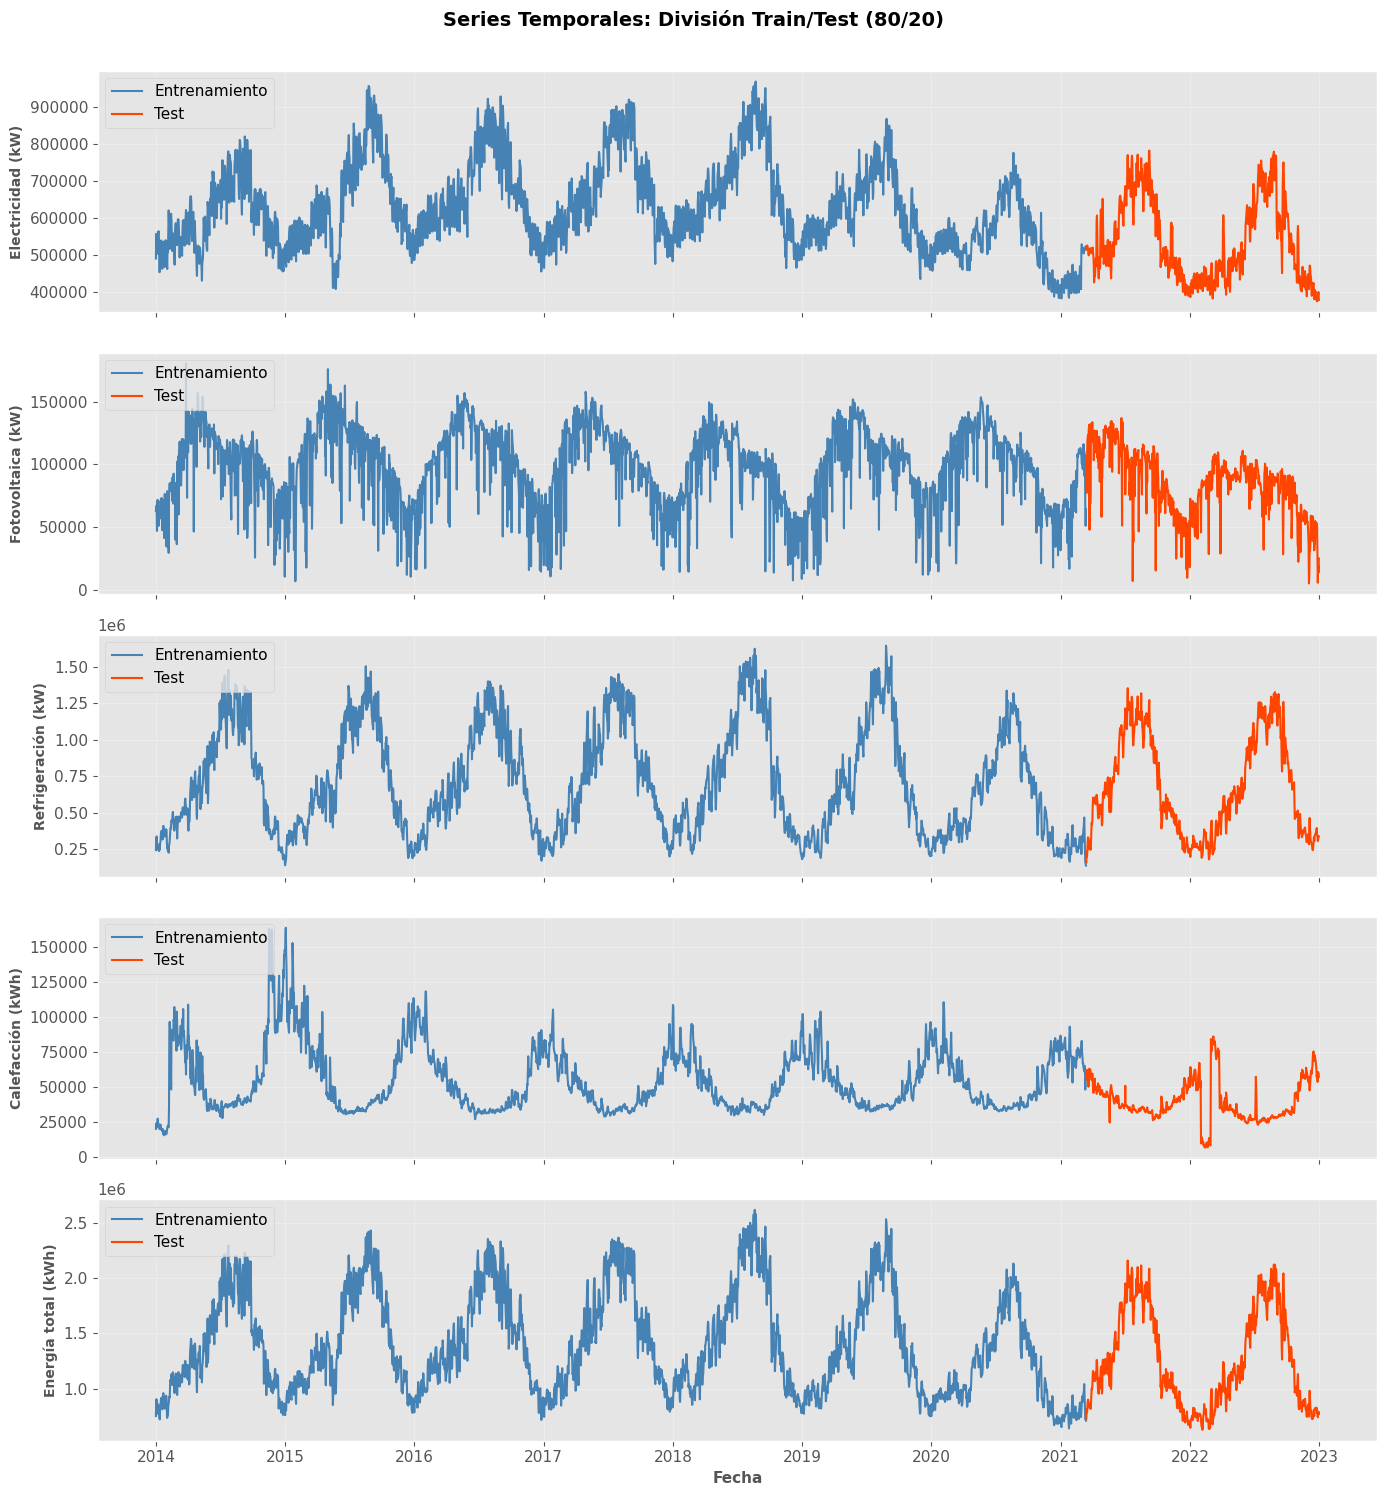

In [6]:
# Visualización de la división train/test
n_series = len(energia_preprocesada.columns)
fig, axes = plt.subplots(n_series, 1, figsize=(14, 3*n_series), sharex=True)

if n_series == 1:
    axes = [axes]

for i, col in enumerate(energia_preprocesada.columns):
    ax = axes[i]
    ax.plot(train_data.index, train_data[col], color='steelblue', label='Entrenamiento', linewidth=1.5)
    ax.plot(test_data.index, test_data[col], color='orangered', label='Test', linewidth=1.5)
    ax.set_ylabel(col, fontsize=10, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Fecha', fontsize=11, fontweight='bold')
fig.suptitle('Series Temporales: División Train/Test (80/20)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

## 2. Modelo Línea Base <a class="anchor" id="linea-base"></a>

Vamos a utilizar un LightGBM como modelo base, es un modelo rápido que nos podrá dar una aproximación de la calidad de los datos. Es tambien el mismo que modelo base que se utilizo en el ejercicio anterior. 
Tambien mantenemos la estrategia de aplicar un enfoque Recursive, ya que los datos presentan una fuerte estacionalidad y la comparación con uni variable será más directa. 


**Configuración:**
Utilizaremos los parámetros por defecto, con un hold out 80/20 para el primer modelo base, con un horizonte de 7 días.

In [25]:
# Crear forecaster con LightGBM (con variables exógenas)
baseline_forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(random_state=SEED, verbose=-1),
    lags=[7],
)
baseline_forecaster.fit(series=train_data, exog=exog_train)

Vamos a visualizar los primeros 7 días predichos con GT para comprobar graficamente como funciona el modelo base.

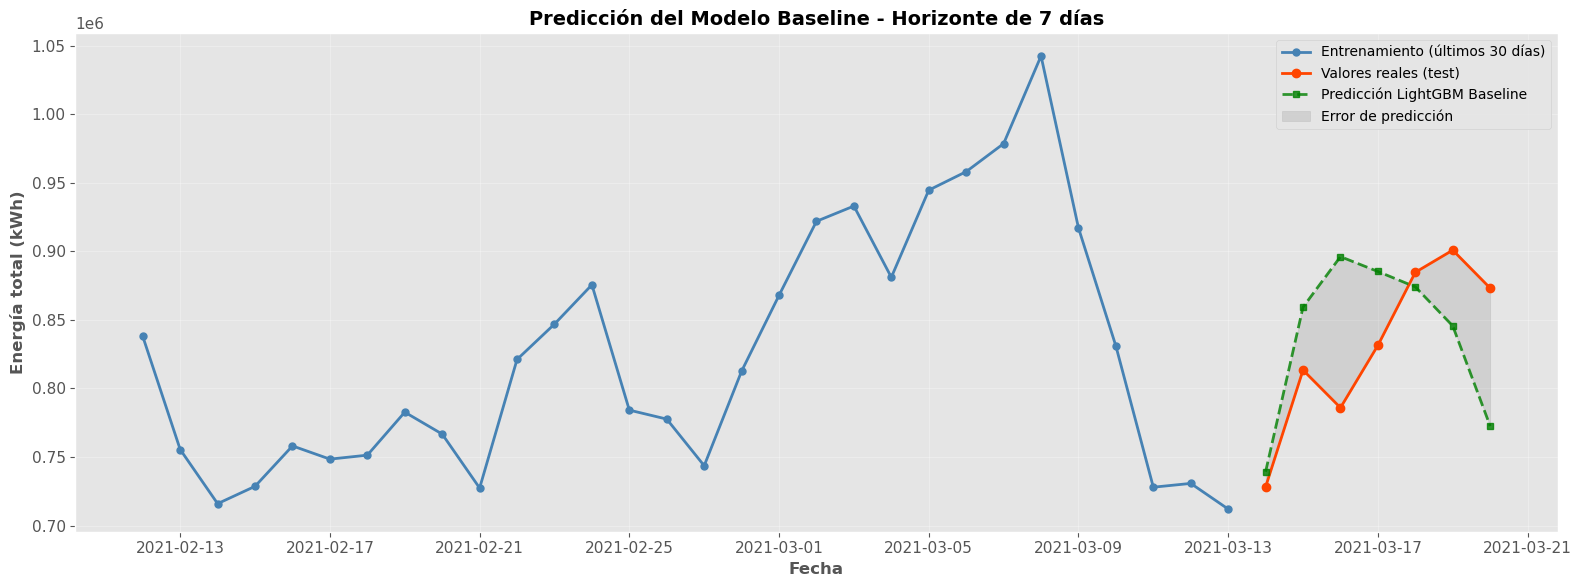


Métricas de la predicción inicial (primeros 7 días):
  • MAE  = 55352.136 kW
  • RMSSE = 1.371 kW
  • R²   = -0.3616


In [8]:
# Predecir los próximos 7 días a partir del final del train
# Necesitamos las exógenas para el periodo de predicción
exog_pred = exog_test.iloc[:HORIZONTE]
prediccion_inicial = baseline_forecaster.predict(steps=HORIZONTE, levels=TARGET, exog=exog_pred)

# Visualizar la predicción
fig, ax = plt.subplots(figsize=(16, 6))

# Mostrar últimos 30 días de entrenamiento
ultimos_dias_train = train_data[TARGET].iloc[-30:]
ax.plot(ultimos_dias_train.index, ultimos_dias_train, 
        'o-', color='steelblue', label='Entrenamiento (últimos 30 días)', 
        linewidth=2, markersize=5)

# Mostrar primeros 7 días de test (valores reales)
primeros_dias_test = test_data[TARGET].iloc[:HORIZONTE]
ax.plot(primeros_dias_test.index, primeros_dias_test, 
        'o-', color='orangered', label='Valores reales (test)', 
        linewidth=2, markersize=6)

# Mostrar predicción del baseline
ax.plot(prediccion_inicial.index, prediccion_inicial['pred'], 
        's--', color='green', label='Predicción LightGBM Baseline', 
        linewidth=2, markersize=5, alpha=0.8)

# Área sombreada para el error
ax.fill_between(primeros_dias_test.index, 
                primeros_dias_test, 
                prediccion_inicial['pred'],
                alpha=0.2, color='gray', label='Error de predicción')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Energía total (kWh)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicción del Modelo Baseline - Horizonte de {HORIZONTE} días', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular métricas básicas de esta predicción inicial
mae_inicial = mean_absolute_error(primeros_dias_test, prediccion_inicial['pred'])

scale = np.mean(np.diff(primeros_dias_test)**2)
mse = mean_squared_error(primeros_dias_test, prediccion_inicial['pred'])
rmsse_inicial = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
r2_inicial = r2_score(primeros_dias_test, prediccion_inicial['pred'])

print(f"\nMétricas de la predicción inicial (primeros {HORIZONTE} días):")
print(f"  • MAE  = {mae_inicial:.3f} kW")
print(f"  • RMSSE = {rmsse_inicial:.3f} kW")
print(f"  • R²   = {r2_inicial:.4f}")

Se puede ver que los resultados son buenos para los primeros 2 días y despues se produce una desviación de más intensas en el tercer, quinto, sexto y septimo día.

## Estrategia de Evaluación <a class="anchor" id="eval"></a>

Para la evaluación vamos a utilziar las mismas métricas que utilizamos en el notebook anterior, R², MAE y RMSE. Estas métricas las utilizaremos con el conjunto de Test, tambien vamos a utilziar Bactesting para comprobar la generalización y overfiting del modelo.

In [9]:
# Función para calcular métricas de evaluación
def calcular_metricas(y_true, y_pred, nombre_modelo="Modelo", verbose=True):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calcular RMSSE (Root Mean Squared Scaled Error)
    # Escala usando las diferencias consecutivas de la serie real
    scale = np.mean(np.diff(y_true)**2)
    mse = mean_squared_error(y_true, y_pred)
    rmsse = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
    
    resultados = {
        'Modelo': nombre_modelo,
        'MAE': mae,
        'R²': r2,
        'RMSSE': rmsse
    }
    if verbose:
        print(f"\nMétricas de {nombre_modelo}:")
        print(f"  • MAE   = {mae:.3f} kWh")    
        print(f"  • R²    = {r2:.4f}")    
        print(f"  • RMSSE = {rmsse:.4f}")
    return resultados

La función anterior genera las métricas  R², MAE y RMSSE para un resultado real y los predichos.

### Estrategia de Evaluación con TimeSeriesFold:
El objeto TimeSeriesFold sería realizar una validación cruzada sobre el conjunto de train, con esto podrémos controlar el overfitting, hemos elegido que comience con un año de datos iniciales de 3 años y que tenga una ventana de un año.

In [ ]:
initial_train_size = 365  # díasç
window_size = 365  # días
# Crear TimeSeriesFold para backtesting
cv = TimeSeriesFold(
    steps=7,                  # Horizonte de predicción
    initial_train_size=initial_train_size,  # Inicial de 366 días
    window_size=window_size,                 # Ventana fija de 7 días
    refit=False,                      # No reentrenar en cada fold
    fixed_train_size=False,           # Ventana fija
    gap=0,                            # Sin gap entre train y test
    allow_incomplete_fold=True,       # Permitir folds incompletos
)
cv.split(X=train_data, as_pandas=True)
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_baseline, predicciones_bt_baseline = backtesting_forecaster_multiseries(
    forecaster=baseline_forecaster,
    series=train_data,  # Serie completa
    #exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric='mean_absolute_error',
    n_jobs='auto',
    verbose=True,
    show_progress=True
)

y_true_baseline = train_data[TARGET].values[initial_train_size:]

y_pred_baseline = predicciones_bt_baseline.values[:,1]

# Calcular métricas completas (MAE, RMSE, R²)
metricas_baseline = calcular_metricas(y_true_baseline, y_pred_baseline, "LightGBM Baseline")


resultados_modelos_cv = [metricas_baseline]


Information of folds
--------------------
Number of observations used for initial training: 365
Number of observations used for backtesting: 2264
    Number of folds: 324
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2014-12-31 00:00:00  (n=365)
    Validation: 2015-01-01 00:00:00 -- 2015-01-07 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2015-01-08 00:00:00 -- 2015-01-14 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2015-01-15 00:00:00 -- 2015-01-21 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2015-01-22 00:00:00 -- 2015-01-28 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2015-01-29 00:00:00 -- 2015-02-04 00:00:00  (n=7)
Fold: 5
    Training:   

ValueError: Length of 'Electricidad (kW)' must be greater than the maximum window size needed by the forecaster.
    Length 'Electricidad (kW)': 365.
    Max window size: 365.
    Lags window size: 365.
    Window features window size: None.

Podemos ver que los resultados para nuestro modelo base son los siguientes: MAE de 1382502.186 KW, R² de -8.5619, este valor suele estar entre 0 y 1 si el valor es negativo denota un error muy alto. Por último el RMSSE es de 14.9

## Modelos Avanzados con Grid Search <a class="anchor" id="modelos"></a>

En esta sección entrenamos tres modelos más avanzados mediante búsqueda de hiperparámetros, los mismos 3 modelos que usamos en el notebook anterior:

- **Random Forest**: Ensemble de árboles de decisión, robusto y efectivo
- **XGBoost**: Gradient boosting optimizado, muy potente en competiciones
- **SVR**: Support Vector Regression, captura relaciones no lineales



### Random Forest con Grid Search <a class="anchor" id="random"></a>

Vamos a comparar dos estrategias de forecasting:
- **Recursivo**: Usa predicciones previas iterativamente
- **Directo**: Entrena un modelo independiente para cada horizonte

Vamos a utilizar en Random Forest los siguientes parametros:

`n_estimators`: 50, 150

`max_depth`: 10, 20

`min_samples_split`: 2, 5

`min_samples_leaf`: 1, 2

Vamos a probar parámetros pequeños para no sobre ajustar demasiado, hay que tener en cuenta que el modelo utilizará todos los lags como variables para predecir.

#### Random Forest Recursivo

In [ ]:
# Crear forecaster recursivo
rf_forecaster = ForecasterRecursiveMultiSeries(
    regressor=RandomForestRegressor(random_state=SEED, n_jobs=-1),
    lags=LAGS,
    encoding='onehot'
)

# Definir grilla de hiperparámetros
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5,10],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4]
}


# Ejecutar grid search con cv específico para validación interna
results_rf = grid_search_forecaster_multiseries(
    forecaster=rf_forecaster,
    series=train_data,
    #exog=exog_train,
    param_grid=param_grid_rf,
    lags_grid=[180,365,730],
    cv=cv,  
    metric='mean_absolute_error',
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

ValueError: No objects to concatenate

Podemos ver que los mejores parámetros han sido: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150} salvo para n_estimators los valores más bajos han dado mejores resultados. Se podría probar en el futuro añadir más n_estimators para ver si mejora el resultado con más arboles

#### Random Forest Directo

In [99]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_rf, predicciones_bt_rf = backtesting_forecaster_multiseries(
    forecaster=rf_forecaster,
    series=train_data,  # Serie completa
    #exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error'],
    n_jobs='auto',
    verbose=True,
    show_progress=True
)

y_true_baseline = train_data[TARGET].values[initial_train_size:]

y_pred_baseline = predicciones_bt_rf['pred'].values

# Calcular métricas completas (MAE, RMSE, R²)
metricas_rf = calcular_metricas(y_true_baseline, y_pred_baseline, "Random Forest (Recursivo)")

# Guardar resultados para comparación posterior
resultados_modelos_cv.append(metricas_rf)


Information of folds
--------------------
Number of observations used for initial training: 1095
Number of observations used for backtesting: 1534
    Number of folds: 220
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-12-30 00:00:00  (n=1095)
    Validation: 2016-12-31 00:00:00 -- 2017-01-06 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2017-01-07 00:00:00 -- 2017-01-13 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2017-01-14 00:00:00 -- 2017-01-20 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2017-01-21 00:00:00 -- 2017-01-27 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2017-01-28 00:00:00 -- 2017-02-03 00:00:00  (n=7)
Fold: 5
    Training: 

  0%|          | 0/220 [00:00<?, ?it/s]


Métricas de Random Forest (Recursivo):
  • MAE   = 121778.669 kWh
  • R²    = 0.8830
  • RMSSE = 1.6557


In [100]:
# Crear forecaster directo
rf_forecaster_directo = ForecasterDirectMultiVariate(
    regressor=RandomForestRegressor(random_state=SEED, n_jobs=-1),
    lags=LAGS,
    steps=HORIZONTE,
    level=TARGET
)

# Realizar backtesting con forecaster directo
metricas_bt_rf_directo, predicciones_bt_rf_directo = backtesting_forecaster_multiseries(
    forecaster=rf_forecaster_directo,
    series=train_data,
    #exog=exog_train,
    cv=cv,
    levels=TARGET,
    metric=['mean_absolute_error'],
    n_jobs='auto',
    verbose=True,
    show_progress=True
)

y_pred_rf_directo = predicciones_bt_rf_directo['pred'].values

# Calcular métricas
metricas_rf_directo = calcular_metricas(y_true_baseline, y_pred_rf_directo, "Random Forest (Directo)")

# Guardar resultados
resultados_modelos_cv.append(metricas_rf_directo)

Information of folds
--------------------
Number of observations used for initial training: 1095
Number of observations used for backtesting: 1534
    Number of folds: 220
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-12-30 00:00:00  (n=1095)
    Validation: 2016-12-31 00:00:00 -- 2017-01-06 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2017-01-07 00:00:00 -- 2017-01-13 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2017-01-14 00:00:00 -- 2017-01-20 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2017-01-21 00:00:00 -- 2017-01-27 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2017-01-28 00:00:00 -- 2017-02-03 00:00:00  (n=7)
Fold: 5
    Training: 

  0%|          | 0/220 [00:00<?, ?it/s]


Métricas de Random Forest (Directo):
  • MAE   = 123247.814 kWh
  • R²    = 0.8884
  • RMSSE = 1.6176


In [101]:


# Ejecutar grid search con lags_grid_directo
results_rf_directo = grid_search_forecaster_multiseries(
    forecaster=rf_forecaster_directo,
    series=train_data,
    #exog=exog_train,
    param_grid=param_grid_rf,
    lags_grid=lags_grid_directo,
    cv=cv,  
    metric='mean_absolute_error',
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/144 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7 365] 
  Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
  Backtesting metric: 122581.70504307942
  Levels: ['Energía total (kWh)']



Encuanto a los resultados ahora tenemos unos valores mejores en todas las métricas en comparación con el modelo base, R² está entre 0 y 1 como se espera.

### XGBoost con Grid Search <a class="anchor" id="xgboost"></a>

Para XGBoost vamos a usar los siguientes parámetros:

`n_estimators`: 50, 100

`max_depth`: 3, 10

`learning_rate`: 0.01, 0.1

`subsample`: 0.8, 1.0

`colsample_bytree`: 0.8, 1.0

#### XGBoost Recursivo

In [ ]:
# Crear forecaster recursivo
xgb_forecaster = ForecasterRecursiveMultiSeries(
    regressor=XGBRegressor(random_state=SEED, n_jobs=-1, verbosity=0),
    lags=LAGS,
    encoding='onehot'
)

# Definir grilla de hiperparámetros
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 10, 15],
    'learning_rate': [0.01,0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}



# Ejecutar grid search con cv específico para validación interna
results_xgb = grid_search_forecaster_multiseries(
    forecaster=xgb_forecaster,
    series=train_data,
    #exog=exog_train,
    param_grid=param_grid_xgb,
    lags_grid=lags_grid_directo,
    cv=cv,  # Usar cv específico para grid search
    metric='mean_absolute_error',
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/144 [00:00<?, ?it/s]

Para XGBoost los mejores parámetros han sido  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}. Un mayor learning rate y numero de estimadores ha dado mejores resultados.

#### XGBoost Directo

In [ ]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_xgb, predicciones_bt_xgb = backtesting_forecaster_multiseries(
    forecaster=xgb_forecaster,
    series=train_data,  # Serie completa
    #exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error'],
    n_jobs='auto',
    verbose=True,
    show_progress=True
)

y_true_xgb = train_data[TARGET].values[initial_train_size:]

y_pred_xgb = predicciones_bt_xgb['pred'].values

# Calcular métricas completas (MAE, RMSE, R²)
metricas_xgb = calcular_metricas(y_true_xgb, y_pred_xgb, "XGBoost (Recursivo)")

# Guardar resultados para comparación posterior
resultados_modelos_cv.append(metricas_xgb)

In [ ]:
# Crear forecaster directo
xgb_forecaster_directo = ForecasterDirectMultiVariate(
    regressor=XGBRegressor(random_state=SEED, n_jobs=-1, verbosity=0),
    lags=LAGS,
    steps=HORIZONTE,
    level=TARGET
)

# Realizar backtesting con forecaster directo
metricas_bt_xgb_directo, predicciones_bt_xgb_directo = backtesting_forecaster_multiseries(
    forecaster=xgb_forecaster_directo,
    series=train_data,
    #exog=exog_train,
    cv=cv,
    levels=TARGET,
    metric=['mean_absolute_error'],
    n_jobs='auto',
    verbose=True,
    show_progress=True
)

y_pred_xgb_directo = predicciones_bt_xgb_directo['pred'].values

# Calcular métricas
metricas_xgb_directo = calcular_metricas(y_true_xgb, y_pred_xgb_directo, "XGBoost (Directo)")

# Guardar resultados
resultados_modelos_cv.append(metricas_xgb_directo)

In [ ]:


# Ejecutar grid search con lags_grid_directo
results_xgb_directo = grid_search_forecaster_multiseries(
    forecaster=xgb_forecaster_directo,
    series=train_data,
    #exog=exog_train,
    param_grid=param_grid_xgb,
    lags_grid=lags_grid_directo,
    cv=cv,
    metric='mean_absolute_error',
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

XGBoost mejora ligeramente los resultados del random forest.

### SVR con Grid Search <a class="anchor" id="svr"></a>

Para SVR vamos a usar los siguientes parámetros:

`kernel`: 'rbf', 

`C`: 0.1. 10

`epsilon`: 0.01, 0.5

`gamma`: 'scale'

#### SVR Recursivo

In [ ]:
# Crear forecaster con datos normalizados (importante para SVR) - Recursivo
svr_forecaster = ForecasterRecursiveMultiSeries(
    regressor=SVR(),
    lags=LAGS,
    encoding='onehot'
)

# Definir grilla de hiperparámetros
param_grid_svr = {
    'kernel': ['rbf'],
    'C': [0.1, 5, 10],
    'epsilon': [0.01, 0.1, 0.5, 1.0],
    'gamma': ['scale']
}


# Ejecutar grid search con cv específico para validación interna
# IMPORTANTE: Usar datos ESCALADOS para SVR
results_svr = grid_search_forecaster_multiseries(
    forecaster=svr_forecaster,
    series=train_data_scaled,  # Datos normalizados
    #exog=exog_train,
    param_grid=param_grid_svr,
    lags_grid=lags_grid_directo,
    cv=cv,  # Usar cv específico para grid search
    metric='mean_absolute_error',
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

Un mayor C y menor epsilon ha dado a priori mejores resultados.

#### SVR Directo

In [ ]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
# IMPORTANTE: Usar datos ESCALADOS para SVR
metricas_bt_svr, predicciones_bt_svr = backtesting_forecaster_multiseries(
    forecaster=svr_forecaster,
    series=train_data_scaled,  # Datos normalizados
    #exog=exog_train,           # Variables exógenas
    cv=cv,                     # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error'],
    n_jobs='auto',
    verbose=True,
    show_progress=True
)

# Obtener valores reales (datos originales, no escalados)
y_true_svr = train_data[TARGET].values[initial_train_size:]

# Desescalar las predicciones para obtener valores en la escala original
y_pred_svr_scaled = predicciones_bt_svr['pred'].values

# Crear array con todas las columnas para desescalar correctamente
# SVR predice solo TARGET, pero necesitamos desescalar en el contexto de todas las features
target_idx = list(train_data.columns).index(TARGET)
y_pred_full = np.zeros((len(y_pred_svr_scaled), len(train_data.columns)))
y_pred_full[:, target_idx] = y_pred_svr_scaled

# Desescalar
y_pred_svr_descaled = scaler.inverse_transform(y_pred_full)[:, target_idx]

# Calcular métricas completas (MAE, RMSE, R²) con valores desescalados
metricas_svr = calcular_metricas(y_true_svr, y_pred_svr_descaled, "Support Vector Regression (Recursivo)")

# Guardar resultados para comparación posterior
resultados_modelos_cv.append(metricas_svr)


In [ ]:
# Crear forecaster directo con datos normalizados (importante para SVR)
svr_forecaster_directo = ForecasterDirectMultiVariate(
    regressor=SVR(),
    lags=LAGS,
    steps=HORIZONTE,
    level=TARGET
)

# Realizar backtesting con forecaster directo
# IMPORTANTE: Usar datos ESCALADOS para SVR
metricas_bt_svr_directo, predicciones_bt_svr_directo = backtesting_forecaster_multiseries(
    forecaster=svr_forecaster_directo,
    series=train_data_scaled,  # Datos normalizados
    #exog=exog_train,
    cv=cv,
    levels=TARGET,
    metric=['mean_absolute_error'],
    n_jobs='auto',
    verbose=True,
    show_progress=True
)

# Desescalar las predicciones
y_pred_svr_directo_scaled = predicciones_bt_svr_directo['pred'].values

# Crear array con todas las columnas para desescalar correctamente
y_pred_full_directo = np.zeros((len(y_pred_svr_directo_scaled), len(train_data.columns)))
y_pred_full_directo[:, target_idx] = y_pred_svr_directo_scaled

# Desescalar
y_pred_svr_directo_descaled = scaler.inverse_transform(y_pred_full_directo)[:, target_idx]

# Calcular métricas con valores desescalados
metricas_svr_directo = calcular_metricas(y_true_svr, y_pred_svr_directo_descaled, "Support Vector Regression (Directo)")

# Guardar resultados
resultados_modelos_cv.append(metricas_svr_directo)

In [ ]:


# Ejecutar grid search con lags_grid_directo
# IMPORTANTE: Usar datos ESCALADOS para SVR
results_svr_directo = grid_search_forecaster_multiseries(
    forecaster=svr_forecaster_directo,
    series=train_data_scaled,  # Datos normalizados
    #exog=exog_train,
    param_grid=param_grid_svr,
    lags_grid=lags_grid_directo,
    cv=cv,
    metric='mean_absolute_error',
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

Este modelo da peores resultados que Random Forest y XGBoost, puede ser por el Grid Search de parámetros que es más reducido que el de los otros dos modelos.

## Comparación y Conclusiones <a class="anchor" id="conclu"></a>

En esta sección final comparamos todos los modelos entrenados y presentamos las conclusiones más relevantes del análisis.

**Nota**: Ahora comparamos 7 modelos:
- 1 Baseline (LightGBM Recursivo)
- 3 Modelos Recursivos (Random Forest, XGBoost, SVR)
- 3 Modelos Directos (Random Forest, XGBoost, SVR)

In [ ]:
# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados_modelos_cv)
df_resultados = df_resultados.sort_values('RMSSE')

print("\nTABLA DE RESULTADOS (ordenado por RMSSE):")
print("\n" + df_resultados.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_rmsse = df_resultados[df_resultados['Modelo'] == 'LightGBM Baseline']['RMSSE'].values[0]
mejor_rmsse = df_resultados.iloc[0]['RMSSE']
mejora = ((baseline_rmsse - mejor_rmsse) / baseline_rmsse) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en RMSSE")

display(df_resultados.style.background_gradient(subset=['MAE', 'RMSSE'], cmap='RdYlGn_r')
                          .background_gradient(subset=['R²'], cmap='RdYlGn')
                          .format({'MAE': '{:.3f}', 'R²': '{:.4f}', 'RMSSE': '{:.4f}'}))

In [ ]:
# Gráfica comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Colores para cada modelo (ahora tenemos 7 modelos)
colors = ['steelblue', 'darkorange', 'lightcoral', 'green', 'lime', 'crimson', 'darkred']

# MAE
axes[0].bar(df_resultados['Modelo'], df_resultados['MAE'], color=colors[:len(df_resultados)])
axes[0].set_ylabel('MAE (kWh)', fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=9)
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(df_resultados['Modelo'], df_resultados['R²'], color=colors[:len(df_resultados)])
axes[1].set_ylabel('R² Score', fontweight='bold')
axes[1].set_title('Coeficiente de Determinación', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=9)
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='R²=0.8')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# RMSSE
axes[2].bar(df_resultados['Modelo'], df_resultados['RMSSE'], color=colors[:len(df_resultados)])
axes[2].set_ylabel('RMSSE', fontweight='bold')
axes[2].set_title('Root Mean Squared Scaled Error', fontweight='bold', fontsize=12)
axes[2].tick_params(axis='x', rotation=45, labelsize=9)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Métricas entre Modelos (Recursivos vs Directos)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# Crear tabla comparativa por tipo de modelo
modelos_base = ['Random Forest', 'XGBoost', 'Support Vector Regression']
comparacion = []

for modelo in modelos_base:
    recursivo = df_resultados[df_resultados['Modelo'] == f'{modelo} (Recursivo)']
    directo = df_resultados[df_resultados['Modelo'] == f'{modelo} (Directo)']
    
    if not recursivo.empty and not directo.empty:
        comparacion.append({
            'Modelo': modelo,
            'MAE Recursivo': recursivo['MAE'].values[0],
            'MAE Directo': directo['MAE'].values[0],
            'Diferencia MAE': directo['MAE'].values[0] - recursivo['MAE'].values[0],
            'R² Recursivo': recursivo['R²'].values[0],
            'R² Directo': directo['R²'].values[0],
            'Diferencia R²': directo['R²'].values[0] - recursivo['R²'].values[0],
            'RMSSE Recursivo': recursivo['RMSSE'].values[0],
            'RMSSE Directo': directo['RMSSE'].values[0],
            'Diferencia RMSSE': directo['RMSSE'].values[0] - recursivo['RMSSE'].values[0]
        })

df_comparacion = pd.DataFrame(comparacion)

print("\n🔄 COMPARACIÓN RECURSIVO vs DIRECTO:")
print("\nValores negativos en 'Diferencia' indican que el método Directo es MEJOR")
display(df_comparacion.style.format({
    'MAE Recursivo': '{:.3f}', 'MAE Directo': '{:.3f}', 'Diferencia MAE': '{:.3f}',
    'R² Recursivo': '{:.4f}', 'R² Directo': '{:.4f}', 'Diferencia R²': '{:.4f}',
    'RMSSE Recursivo': '{:.4f}', 'RMSSE Directo': '{:.4f}', 'Diferencia RMSSE': '{:.4f}'
}))

In [ ]:
# Visualización de la comparación Recursivo vs Directo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x = np.arange(len(modelos_base))
width = 0.35

for i, metrica in enumerate(['MAE', 'R²', 'RMSSE']):
    recursivo_vals = df_comparacion[f'{metrica} Recursivo'].values
    directo_vals = df_comparacion[f'{metrica} Directo'].values
    
    axes[i].bar(x - width/2, recursivo_vals, width, label='Recursivo', color='steelblue', alpha=0.8)
    axes[i].bar(x + width/2, directo_vals, width, label='Directo', color='darkorange', alpha=0.8)
    
    axes[i].set_xlabel('Modelo', fontweight='bold')
    axes[i].set_ylabel(metrica, fontweight='bold')
    axes[i].set_title(f'Comparación {metrica}', fontweight='bold', fontsize=12)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(modelos_base, rotation=45, ha='right')
    axes[i].legend()
    axes[i].grid(axis='y', alpha=0.3)

plt.suptitle('Recursivo vs Directo por Modelo', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Comparación Recursivo vs Directo

Analicemos las diferencias entre las dos estrategias de forecasting:

## Uso de IA Generativa <a class="anchor" id="genia"></a>


**Prompt**: En base a un dataframe con las siguientes columnas Modelo, MAE, R2 y RMSSE, crea una visualización con diagrama de barras de los distintos errores, por modelo. 
Además crea una tabla con los valores ordenados por RMSSE para ver que modelo funciona mejor.

```Python

print("\n📈 GRÁFICA COMPARATIVA DE MÉTRICAS:")

# Gráfica comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colores para cada modelo
colors = ['steelblue', 'darkorange', 'green', 'crimson']

# MAE
axes[0].bar(df_resultados['Modelo'], df_resultados['MAE'], color=colors)
axes[0].set_ylabel('MAE (kWh)', fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(df_resultados['Modelo'], df_resultados['R²'], color=colors)
axes[1].set_ylabel('R² Score', fontweight='bold')
axes[1].set_title('Coeficiente de Determinación', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='R²=0.8')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# RMSSE
axes[2].bar(df_resultados['Modelo'], df_resultados['RMSSE'], color=colors)
axes[2].set_ylabel('RMSSE', fontweight='bold')
axes[2].set_title('Root Mean Squared Scaled Error', fontweight='bold', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Métricas entre Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


print("\nTABLA DE RESULTADOS (ordenado por RMSSE):")
print("\n" + df_resultados.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_rmsse = df_resultados[df_resultados['Modelo'] == 'LightGBM Baseline']['RMSSE'].values[0]
mejor_rmsse = df_resultados.iloc[0]['RMSSE']
mejora = ((baseline_rmsse - mejor_rmsse) / baseline_rmsse) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en RMSSE")

display(df_resultados.style.background_gradient(subset=['MAE', 'RMSSE'], cmap='RdYlGn_r')
                          .background_gradient(subset=['R²'], cmap='RdYlGn')
                          .format({'MAE': '{:.3f}', 'R²': '{:.4f}', 'RMSSE': '{:.4f}'}))
```
**Prompt**: Crea una gráfica para mostrar los resultados de predicción del siguiente modelo:
prediccion_inicial = baseline_forecaster.predict(steps=HORIZONTE, levels=TARGET)
con HORIZONTE=7 y TARGET = Energía total (kWh). Ten en cuenta que quiero mostrar los 30 días anteriores a la predicción y el resultado predicho y el resultado original. Calcula tambien el MAE, RMSSE y R2.

**Consideraciones**: El código se tuvo  que adaptar, principalmente nombres de variales y accesos a diccionraios
```Python
# Gráfica comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colores para cada modelo
colors = ['steelblue', 'darkorange', 'green', 'crimson']

# MAE
axes[0].bar(df_resultados['Modelo'], df_resultados['MAE'], color=colors)
axes[0].set_ylabel('MAE (kWh)', fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(df_resultados['Modelo'], df_resultados['R²'], color=colors)
axes[1].set_ylabel('R² Score', fontweight='bold')
axes[1].set_title('Coeficiente de Determinación', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='R²=0.8')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# RMSSE
axes[2].bar(df_resultados['Modelo'], df_resultados['RMSSE'], color=colors)
axes[2].set_ylabel('RMSSE', fontweight='bold')
axes[2].set_title('Root Mean Squared Scaled Error', fontweight='bold', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Métricas entre Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


# Visualizar la predicción
fig, ax = plt.subplots(figsize=(16, 6))

# Mostrar últimos 30 días de entrenamiento
ultimos_dias_train = train[TARGET].iloc[-30:]
ax.plot(ultimos_dias_train.index, ultimos_dias_train, 
        'o-', color='steelblue', label='Entrenamiento (últimos 30 días)', 
        linewidth=2, markersize=5)

# Mostrar primeros 7 días de test (valores reales)
primeros_dias_test = test[TARGET].iloc[:HORIZONTE]
ax.plot(primeros_dias_test.index, primeros_dias_test, 
        'o-', color='orangered', label='Valores reales (test)', 
        linewidth=2, markersize=6)

# Mostrar predicción del baseline
ax.plot(prediccion_inicial.index, prediccion_inicial.value, 
        's--', color='green', label='Predicción LightGBM Baseline', 
        linewidth=2, markersize=5, alpha=0.8)

# Área sombreada para el error
ax.fill_between(primeros_dias_test.index, 
                primeros_dias_test, 
                prediccion_inicial.value,
                alpha=0.2, color='gray', label='Error de predicción')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Energía total (kWh)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicción del Modelo Baseline - Horizonte de {HORIZONTE} días', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular métricas básicas de esta predicción inicial
mae_inicial = mean_absolute_error(primeros_dias_test, prediccion_inicial['pred'])

scale = np.mean(np.diff(primeros_dias_test)**2)
mse = mean_squared_error(primeros_dias_test, prediccion_inicial['pred'])
rmsse_inicial = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
r2_inicial = r2_score(primeros_dias_test, prediccion_inicial['pred'])

print(f"\nMétricas de la predicción inicial (primeros {HORIZONTE} días):")
print(f"  • MAE  = {mae_inicial:.3f} kW")
print(f"  • RMSSE = {rmsse_inicial:.3f} kW")
print(f"  • R²   = {r2_inicial:.4f}")

```


## Entorno de Ejecución <a class="anchor" id="entorno"></a>

In [ ]:
import sklearn
sklearn.show_versions()

In [ ]:
from sinfo import sinfo

sinfo()

Resultado Recursivo previo con Emisiones y sin usar el lag de hace un año

<style type="text/css">
#T_22f64_row0_col1, #T_22f64_row0_col2, #T_22f64_row0_col3, #T_22f64_row1_col1, #T_22f64_row1_col2, #T_22f64_row1_col3, #T_22f64_row2_col1, #T_22f64_row2_col2 {
  background-color: #006837;
  color: #f1f1f1;
}
#T_22f64_row2_col3 {
  background-color: #016a38;
  color: #f1f1f1;
}
#T_22f64_row3_col1, #T_22f64_row3_col2, #T_22f64_row3_col3 {
  background-color: #a50026;
  color: #f1f1f1;
}
</style>
<table id="T_22f64">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_22f64_level0_col0" class="col_heading level0 col0" >Modelo</th>
      <th id="T_22f64_level0_col1" class="col_heading level0 col1" >MAE</th>
      <th id="T_22f64_level0_col2" class="col_heading level0 col2" >R²</th>
      <th id="T_22f64_level0_col3" class="col_heading level0 col3" >RMSSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_22f64_level0_row0" class="row_heading level0 row0" >3</th>
      <td id="T_22f64_row0_col0" class="data row0 col0" >Support Vector Regression</td>
      <td id="T_22f64_row0_col1" class="data row0 col1" >117703.017</td>
      <td id="T_22f64_row0_col2" class="data row0 col2" >0.8942</td>
      <td id="T_22f64_row0_col3" class="data row0 col3" >1.5751</td>
    </tr>
    <tr>
      <th id="T_22f64_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_22f64_row1_col0" class="data row1 col0" >XGBoost</td>
      <td id="T_22f64_row1_col1" class="data row1 col1" >113668.079</td>
      <td id="T_22f64_row1_col2" class="data row1 col2" >0.8914</td>
      <td id="T_22f64_row1_col3" class="data row1 col3" >1.5954</td>
    </tr>
    <tr>
      <th id="T_22f64_level0_row2" class="row_heading level0 row2" >1</th>
      <td id="T_22f64_row2_col0" class="data row2 col0" >Random Forest</td>
      <td id="T_22f64_row2_col1" class="data row2 col1" >117840.469</td>
      <td id="T_22f64_row2_col2" class="data row2 col2" >0.8869</td>
      <td id="T_22f64_row2_col3" class="data row2 col3" >1.6279</td>
    </tr>
    <tr>
      <th id="T_22f64_level0_row3" class="row_heading level0 row3" >0</th>
      <td id="T_22f64_row3_col0" class="data row3 col0" >LightGBM Baseline</td>
      <td id="T_22f64_row3_col1" class="data row3 col1" >1382502.186</td>
      <td id="T_22f64_row3_col2" class="data row3 col2" >-8.5619</td>
      <td id="T_22f64_row3_col3" class="data row3 col3" >14.9712</td>
    </tr>
  </tbody>
</table>

Resultado recursivo previo sin emisiones y con el lags [1,2,3,4,5,6,7,365]

<style type="text/css">
#T_2c916_row0_col1, #T_2c916_row0_col2, #T_2c916_row0_col3, #T_2c916_row1_col2, #T_2c916_row1_col3, #T_2c916_row2_col2 {
  background-color: #006837;
  color: #f1f1f1;
}
#T_2c916_row1_col1 {
  background-color: #016a38;
  color: #f1f1f1;
}
#T_2c916_row2_col1, #T_2c916_row2_col3 {
  background-color: #026c39;
  color: #f1f1f1;
}
#T_2c916_row3_col1, #T_2c916_row3_col2, #T_2c916_row3_col3 {
  background-color: #a50026;
  color: #f1f1f1;
}
</style>
<table id="T_2c916">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_2c916_level0_col0" class="col_heading level0 col0" >Modelo</th>
      <th id="T_2c916_level0_col1" class="col_heading level0 col1" >MAE</th>
      <th id="T_2c916_level0_col2" class="col_heading level0 col2" >R²</th>
      <th id="T_2c916_level0_col3" class="col_heading level0 col3" >RMSSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_2c916_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_2c916_row0_col0" class="data row0 col0" >Random Forest</td>
      <td id="T_2c916_row0_col1" class="data row0 col1" >112091.915</td>
      <td id="T_2c916_row0_col2" class="data row0 col2" >0.8969</td>
      <td id="T_2c916_row0_col3" class="data row0 col3" >1.5545</td>
    </tr>
    <tr>
      <th id="T_2c916_level0_row1" class="row_heading level0 row1" >3</th>
      <td id="T_2c916_row1_col0" class="data row1 col0" >Support Vector Regression</td>
      <td id="T_2c916_row1_col1" class="data row1 col1" >117655.759</td>
      <td id="T_2c916_row1_col2" class="data row1 col2" >0.8963</td>
      <td id="T_2c916_row1_col3" class="data row1 col3" >1.5589</td>
    </tr>
    <tr>
      <th id="T_2c916_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_2c916_row2_col0" class="data row2 col0" >XGBoost</td>
      <td id="T_2c916_row2_col1" class="data row2 col1" >123646.833</td>
      <td id="T_2c916_row2_col2" class="data row2 col2" >0.8799</td>
      <td id="T_2c916_row2_col3" class="data row2 col3" >1.6781</td>
    </tr>
    <tr>
      <th id="T_2c916_level0_row3" class="row_heading level0 row3" >0</th>
      <td id="T_2c916_row3_col0" class="data row3 col0" >LightGBM Baseline</td>
      <td id="T_2c916_row3_col1" class="data row3 col1" >1382502.186</td>
      <td id="T_2c916_row3_col2" class="data row3 col2" >-8.5619</td>
      <td id="T_2c916_row3_col3" class="data row3 col3" >14.9712</td>
    </tr>
  </tbody>
</table>

Resultados recursivo y directo con varios lags [1..7, 365],[1..14, 365],[1..21, 365]

<style type="text/css">
#T_407fa_row0_col1, #T_407fa_row4_col1 {
  background-color: #016a38;
  color: #f1f1f1;
}
#T_407fa_row0_col2, #T_407fa_row0_col3, #T_407fa_row1_col1, #T_407fa_row1_col2, #T_407fa_row1_col3, #T_407fa_row2_col1, #T_407fa_row2_col2, #T_407fa_row2_col3, #T_407fa_row3_col1, #T_407fa_row3_col2, #T_407fa_row3_col3, #T_407fa_row4_col2, #T_407fa_row4_col3, #T_407fa_row5_col2 {
  background-color: #006837;
  color: #f1f1f1;
}
#T_407fa_row5_col1 {
  background-color: #04703b;
  color: #f1f1f1;
}
#T_407fa_row5_col3 {
  background-color: #036e3a;
  color: #f1f1f1;
}
#T_407fa_row6_col1, #T_407fa_row6_col2, #T_407fa_row6_col3 {
  background-color: #a50026;
  color: #f1f1f1;
}
</style>
<table id="T_407fa">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_407fa_level0_col0" class="col_heading level0 col0" >Modelo</th>
      <th id="T_407fa_level0_col1" class="col_heading level0 col1" >MAE</th>
      <th id="T_407fa_level0_col2" class="col_heading level0 col2" >R²</th>
      <th id="T_407fa_level0_col3" class="col_heading level0 col3" >RMSSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_407fa_level0_row0" class="row_heading level0 row0" >6</th>
      <td id="T_407fa_row0_col0" class="data row0 col0" >Support Vector Regression (Directo)</td>
      <td id="T_407fa_row0_col1" class="data row0 col1" >116446.240</td>
      <td id="T_407fa_row0_col2" class="data row0 col2" >0.8990</td>
      <td id="T_407fa_row0_col3" class="data row0 col3" >1.5385</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row1" class="row_heading level0 row1" >3</th>
      <td id="T_407fa_row1_col0" class="data row1 col0" >XGBoost (Recursivo)</td>
      <td id="T_407fa_row1_col1" class="data row1 col1" >110924.292</td>
      <td id="T_407fa_row1_col2" class="data row1 col2" >0.8987</td>
      <td id="T_407fa_row1_col3" class="data row1 col3" >1.5409</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row2" class="row_heading level0 row2" >5</th>
      <td id="T_407fa_row2_col0" class="data row2 col0" >Support Vector Regression (Recursivo)</td>
      <td id="T_407fa_row2_col1" class="data row2 col1" >115647.635</td>
      <td id="T_407fa_row2_col2" class="data row2 col2" >0.8983</td>
      <td id="T_407fa_row2_col3" class="data row2 col3" >1.5439</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row3" class="row_heading level0 row3" >1</th>
      <td id="T_407fa_row3_col0" class="data row3 col0" >Random Forest (Recursivo)</td>
      <td id="T_407fa_row3_col1" class="data row3 col1" >112091.915</td>
      <td id="T_407fa_row3_col2" class="data row3 col2" >0.8969</td>
      <td id="T_407fa_row3_col3" class="data row3 col3" >1.5545</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row4" class="row_heading level0 row4" >2</th>
      <td id="T_407fa_row4_col0" class="data row4 col0" >Random Forest (Directo)</td>
      <td id="T_407fa_row4_col1" class="data row4 col1" >120211.642</td>
      <td id="T_407fa_row4_col2" class="data row4 col2" >0.8922</td>
      <td id="T_407fa_row4_col3" class="data row4 col3" >1.5899</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row5" class="row_heading level0 row5" >4</th>
      <td id="T_407fa_row5_col0" class="data row5 col0" >XGBoost (Directo)</td>
      <td id="T_407fa_row5_col1" class="data row5 col1" >131325.082</td>
      <td id="T_407fa_row5_col2" class="data row5 col2" >0.8703</td>
      <td id="T_407fa_row5_col3" class="data row5 col3" >1.7433</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row6" class="row_heading level0 row6" >0</th>
      <td id="T_407fa_row6_col0" class="data row6 col0" >LightGBM Baseline</td>
      <td id="T_407fa_row6_col1" class="data row6 col1" >1382502.186</td>
      <td id="T_407fa_row6_col2" class="data row6 col2" >-8.5619</td>
      <td id="T_407fa_row6_col3" class="data row6 col3" >14.9712</td>
    </tr>
  </tbody>
</table>

# TODO: Solo recursivo
# TODO: Métricas MAE, RMSE, RMSSE, MAPE
# TODO: Grid de lags